In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Train_full.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [3]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# ## UNCOMMENT BELOW SECTION AND COMMENT OUT DEEPSPEED SECTION TO AVOID USING DEEPSPEED ###
use_deepspeed = False
accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
global_batch_size = batch_size = 32
data_type = torch.float16 # change depending on your mixed_precision

### DEEPSPEED INITIALIZATION ###
# use_deepspeed = True
# import deepspeed
# if num_devices <= 1 and utils.is_interactive():
#     global_batch_size = batch_size = 128
#     print(f"Setting batch_size to {batch_size}")
#     # can emulate a distributed environment for deepspeed to work in jupyter notebook
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
#     os.environ["RANK"] = "0"
#     os.environ["LOCAL_RANK"] = "0"
#     os.environ["WORLD_SIZE"] = "1"
#     os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
# else:
#     global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]    
#     batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices
#     if num_devices <= 1:
#         os.environ["RANK"] = "0"
#         os.environ["LOCAL_RANK"] = "0"
#         os.environ["WORLD_SIZE"] = "1"

# # alter the deepspeed config according to your global and local batch size
# if local_rank == 0:
#     with open('deepspeed_config_stage2_cpuoffload.json', 'r') as file:
#         config = json.load(file)
#     config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
#     config['train_micro_batch_size_per_gpu'] = batch_size
#     config['bf16'] = {'enabled': False}
#     config['fp16'] = {'enabled': True}
#     with open('deepspeed_config_stage2_cpuoffload.json', 'w') as file:
#         json.dump(config, file)
# else:
#     # give some time for the local_rank=0 gpu to prep new deepspeed config file
#     time.sleep(10)
# deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2_cpuoffload.json")
# accelerator = Accelerator(split_batches=False, deepspeed_plugin=deepspeed_plugin)

LOCAL RANK  0


In [4]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 1534777
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [5]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # create random model_name
    # model_name = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
    # model_name = model_name + "_interactive"
    model_name = "full_r6000_3ses"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --subj=1 --subj_list=1 --batch_size={batch_size} --blurry_recon --depth_recon --num_sessions=3 \
                    --clip_scale=1. --blur_scale=100. --depth_scale=100. --attn_dim=6000 --hidden_dim=1024 --seq_len=1 --n_blocks=4 \
                    --max_lr=3e-4 --mixup_pct=.66 --num_epochs=12 --ckpt_interval=999 --no-use_image_aug --ckpt_saving --wandb_log" #--resume_from_ckpt 
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: full_r6000_3ses
--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset                     --model_name=full_r6000_3ses                     --subj=1 --subj_list=1 --batch_size=32 --blurry_recon --depth_recon --num_sessions=3                     --clip_scale=1. --blur_scale=100. --depth_scale=100. --attn_dim=6000 --hidden_dim=1024 --seq_len=1 --n_blocks=4                     --max_lr=3e-4 --mixup_pct=.66 --num_epochs=12 --ckpt_interval=999 --no-use_image_aug --ckpt_saving --wandb_log


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (zero = all sessions)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--depth_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output depth reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=100.,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--depth_scale",type=float,default=100.,
    help="multiply loss from depth recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--subj_list", type=int, nargs='+', default=[2,3,4,5,6,7,8],
    help="number of subjects"
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--attn_dim",type=int,default=4096,
)
parser.add_argument(
    "--hidden_dim",type=int,default=4096,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 3


In [7]:
outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [8]:
def my_split_by_node(urls): return urls
num_voxels_list = []

num_samples_per_epoch = 12800 // num_devices 

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))
nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])-3 # 3 sessions are withheld for algonauts

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch,)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 32 num_iterations_per_epoch = 400 num_samples_per_epoch = 12800


In [9]:
train_data = {}
train_dl = {}
num_voxels = {}
voxels = {}
for s in subj_list:
    if num_sessions == 0:
        print(f"Training with all sessions")
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{" + f"0..{nsessions_allsubj[s-1]-1}" + "}.tar"
    else:
        print(f"Training with only {num_sessions} sessions")
        train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
    print(train_url)
    
    train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=1500, rng=random.Random(42))\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    train_dl[f'subj0{s}'] = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

    # Load hdf5 data for betas, but don't put everything into memory
    f = h5py.File(f'{data_path}/betas_all_subj0{s}.hdf5', 'r')
    # f = h5py.File(f'{data_path}/betas_subj0{subj}_thresholded_wholebrain.hdf5', 'r')
    
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu").to(data_type)
    num_voxels_list.append(betas[0].shape[-1])
    num_voxels[f'subj0{s}'] = betas[0].shape[-1]
    voxels[f'subj0{s}'] = betas
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and betas!\n")

# Validate only on one subject
num_test = 2770
test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Training with only 3 sessions
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar
num_voxels for subj01: 15724
Loaded all subj train dls and betas!

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar
Loaded test dl for subj1!



In [10]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

# # Load all COCO images
# f = h5py.File('trainval_coco_images_224_float16.hdf5', 'r')
# coco_images = f['images'][:]
# coco_images = torch.Tensor(coco_images).to("cpu").to(data_type)
# print("Loaded all 112k possible trainval COCO images to cpu!", coco_images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


### check dataloaders are working

In [11]:
# test_vox_indices = []
# test_73k_images = []
# for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
#     test_vox_indices = np.append(test_vox_indices, behav[:,0,5].cpu().numpy())
#     test_73k_images = np.append(test_73k_images, behav[:,0,0].cpu().numpy())
# test_vox_indices = test_vox_indices.astype(np.int16)
# print(test_i, (test_i+1) * num_test, len(test_vox_indices))
# print("---\n")

# train_vox_indices = []
# train_73k_images = []
# for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
#     train_vox_indices = np.append(train_vox_indices, behav[:,0,5].long().cpu().numpy())
#     train_73k_images = np.append(train_73k_images, behav[:,0,0].cpu().numpy())
# train_vox_indices = train_vox_indices.astype(np.int16)
# print(train_i, (train_i+1) * batch_size, len(train_vox_indices))

# all_vox_indices = np.hstack((train_vox_indices, test_vox_indices))
# all_images = np.hstack((train_73k_images, test_73k_images))

## Load models

### CLIP image embeddings  model

In [12]:
from models import Clipper
clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)
clip_seq_dim = 257
clip_emb_dim = 768 #1024
# seq_len = 1 #32 

ViT-L/14 cuda:0


### SD VAE

In [13]:
# if blurry_recon:
#     from diffusers import AutoencoderKL
#     autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
#     # autoenc.load_state_dict(torch.load('../train_logs/sdxl_vae_normed/best.pth')["model_state_dict"])
#     autoenc.eval()
#     autoenc.requires_grad_(False)
#     autoenc.to(device)
#     utils.count_params(autoenc)

if blurry_recon:# or depth_recon:
    from diffusers import VQModel
    autoenc = VQModel.from_pretrained("/fsx/proj-fmri/shared/cache/models--microsoft--vq-diffusion-ithq/snapshots/3f796fb49ee559370dc638dea1d8116af131d993/vqvae", torch_dtype=data_type)
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)

param counts:
64,009,667 total
0 trainable


#### downsampled images

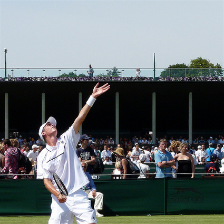

torch.Size([1, 3, 224, 224])
torch.Size([1, 128, 16, 16])


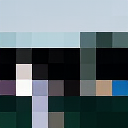

In [14]:
if blurry_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30]].to(device)
    print(input_batch.shape)

    downsampled_image = nn.functional.interpolate(input_batch, size=(8, 8), mode='bilinear', align_corners=False)
    re_upsampled_image = nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest')
    re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
    print(re_upsampled_enc.shape)
    
    if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(re_upsampled_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

#### MiDaS depth

In [15]:
if depth_recon:
    from controlnet_aux.midas import MidasDetector
    
    midas_depth = MidasDetector.from_pretrained(
      "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large", cache_dir="/fsx/proj-fmri/shared/cache").to(device)
    midas_depth.model.eval()
    midas_depth.model.requires_grad_(False)
    midas_depth.model.to(device)
    pass

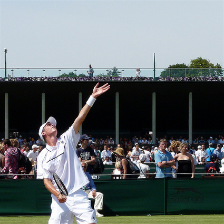

torch.Size([2, 3, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 32, 32])
midas_emb torch.Size([2, 1, 32, 32]) tensor(0., device='cuda:0', dtype=torch.float16) tensor(1., device='cuda:0', dtype=torch.float16)
midas_emb_size 1024


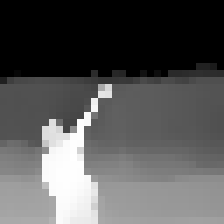

vae midas_emb torch.Size([2, 128, 16, 16]) tensor(-0.9912, device='cuda:0', dtype=torch.float16) tensor(0.9131, device='cuda:0', dtype=torch.float16)


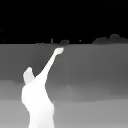

In [16]:
if depth_recon:
    if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

    input_batch = images[[30,31]].float().to(device)
    print(input_batch.shape)
    
    midas_emb = midas_depth.model(input_batch).unsqueeze(1)
    print(midas_emb.shape)

    prediction = utils.resize(midas_emb, 32) #/30).clamp(0,1).half() # 30 is roughly prediction.max()
    print(prediction.shape)
    
    prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
    midas_emb_size = prediction.flatten(1).shape[1]
    print("midas_emb", prediction.shape, prediction.min(), prediction.max())
    print("midas_emb_size", midas_emb_size)
    
    if utils.is_interactive(): display(utils.torch_to_Image(utils.resize(prediction, 224))) 

    if blurry_recon:
        prediction = utils.resize(midas_emb, 128).half().repeat(1,3,1,1)
        prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
        prediction_enc = autoenc.encode(2*prediction-1).latents * 0.18215
        print("vae midas_emb", prediction_enc.shape, prediction_enc.min(), prediction_enc.max())
    
        if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(prediction_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

### MindEye modules

In [17]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [18]:
class SelfAttention(nn.Module):
    #https://github.com/fastai/course22p2/blob/master/nbs/28_diffusion-attn-cond.ipynb
    def __init__(self, ni, attn_chans, out):
        super().__init__()
        self.nheads = ni//attn_chans
        self.scale = math.sqrt(ni/self.nheads)
        self.norm = nn.LayerNorm(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, out)
    def forward(self, x):
        n,c,s = x.shape
        x = self.norm(x)
        x = self.qkv(x)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nheads)
        x = self.proj(x)
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len, ridge_hidden_dim): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
            torch.nn.ModuleList([
                nn.Linear(input_size, ridge_hidden_dim) for input_size in input_sizes
            ]) for seq in range(seq_len)
        ])
        self.attention = torch.nn.ModuleList([
                SelfAttention(ridge_hidden_dim*seq_len, 8, out_features) for input_size in input_sizes
            ])
        self.temp = nn.Parameter(torch.Tensor([5.3]))
        self.bias = nn.Parameter(torch.Tensor([-2.]))
    def forward(self, x, subj_idx):
        x = torch.cat([self.linears[seq][subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        x = x.flatten(1).unsqueeze(1)
        out = self.attention[subj_idx](x)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, ridge_hidden_dim=attn_dim, out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,seq_len,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
208,525,026 total
208,525,026 trainable
param counts:
208,525,026 total
208,525,026 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 1024])


In [19]:
# class RidgeRegression(torch.nn.Module):
#     # make sure to add weight_decay when initializing optimizer
#     def __init__(self, input_sizes, out_features, seq_len): 
#         super(RidgeRegression, self).__init__()
#         self.out_features = out_features
#         self.linears = torch.nn.ModuleList([
#             torch.nn.ModuleList([
#                 torch.nn.Linear(input_size, out_features) for input_size in input_sizes
#             ]) for seq in range(seq_len)
#         ])
#         self.temp = nn.Parameter(torch.Tensor([5.3]))
#         self.bias = nn.Parameter(torch.Tensor([-2.]))
#     def forward(self, x, subj_idx):
#         out = torch.cat([self.linears[seq][subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
#         return out
        
# model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)
# utils.count_params(model.ridge)
# utils.count_params(model)

# # test on subject 1 with fake data
# b = torch.randn((2,seq_len,num_voxels_list[0]))
# print(b.shape, model.ridge(b,0).shape)

In [20]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, seq_len=2, h=4096, n_blocks=n_blocks, drop=.15, clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        # Initial linear layer to match the input dimensions to hidden dimensions
        # self.lin0 = nn.Linear(in_dim, seq_len * h)

        # self.attention = SelfAttention(seq_len*hidden_dim, attn_dim)
        
        # Mixer Blocks
        self.mixer_ln1 = nn.ModuleList([
            self.ln(h) for _ in range(n_blocks)
        ])
        self.mixer_blocks1 = nn.ModuleList([
            self.mlp(seq_len, seq_len, drop) for _ in range(n_blocks)
        ])
        self.mixer_ln2 = nn.ModuleList([
            self.ln(h) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mlp(h, h, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.clin1 = nn.Linear(h * seq_len, out_dim, bias=True)

        self.clip_proj = nn.Sequential(
            nn.LayerNorm(clip_size),
            nn.GELU(),
            nn.Linear(clip_size, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, clip_size)
        )

        if blurry_recon:
            # self.blin1 = nn.Sequential(
            #     nn.Linear(out_dim, 4096, bias=True),
            #     nn.LayerNorm(4096),
            #     nn.GELU(),
            #     nn.Linear(4096, 4096))
            self.blin1 = nn.Linear(h*seq_len, 4096)
            self.bgroupnorm = nn.GroupNorm(1, 256)
            self.bupsampler = Decoder(
                in_channels=256,
                out_channels=128,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128],
                layers_per_block=1,
            )

        if depth_recon:
            # self.dlin1 = nn.Sequential(
            #         nn.Linear(h, midas_emb_size),
            #         nn.Sigmoid(),
            #     )
            self.dlin1 = nn.Linear(h*seq_len, 4096)
            self.dgroupnorm = nn.GroupNorm(1, 256)
            self.dupsampler = Decoder(
                in_channels=256,
                out_channels=1,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128, 256],
                layers_per_block=1,
            )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )

    def ln(self, dim):
        return nn.LayerNorm(dim)
        
    def forward(self, x):
        # make empty tensors for blur and depth outputs
        b,d = torch.Tensor([0.]), torch.Tensor([0.])
        
        # Initial linear layer
        # x = self.lin0(x)

        # shape = x.shape
        # x = self.attention(x.flatten(1)).reshape(shape)
        
        # Mixer blocks
        residual1 = x.permute(0,2,1)
        residual2 = x
        for ln1, block1, ln2, block2 in zip(self.mixer_ln1, self.mixer_blocks1, self.mixer_ln2, self.mixer_blocks2):
            # Layer norm before transpose
            x = ln1(x)
            x = x.permute(0,2,1)
            
            # Channel mixing
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            # Embedding mixing
            x = ln2(x)
            x = block2(x) + residual2
            residual2 = x
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        
        c = self.clin1(x)
        
        c = self.clip_proj(c.reshape(len(c), -1, self.clip_size))

        if blurry_recon:
            b = self.blin1(x)
            b = b.reshape(len(b), 256, 4, 4)
            b = self.bgroupnorm(b)
            b = self.bupsampler(b)
            
        if depth_recon:
            d = self.dlin1(x)#.reshape(len(x), 1, 32, 32)
            d = d.reshape(len(d), 256, 4, 4)
            d = self.dgroupnorm(d)
            d = self.dupsampler(d)
        
        return c, b, d

utils.seed_everything(seed=0, cudnn_deterministic=True)
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,hidden_dim))
print("b.shape",b.shape)

clip_, blur_, depth_ = model.backbone(b)
print(clip_.shape, blur_.shape, depth_.shape)

param counts:
235,851,249 total
235,851,249 trainable
param counts:
444,376,275 total
444,376,275 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 257, 768]) torch.Size([2, 128, 16, 16]) torch.Size([2, 1, 32, 32])


In [21]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    # try:
    if use_deepspeed:
        deepspeed.DeepSpeedEngine.save_checkpoint(model, save_dir=outdir, tag=tag)
        ckpt_path = outdir+f'/{tag}/{tag}.npy'
        np.save(ckpt_path, {
            'epoch': epoch,
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs})
    else:
        ckpt_path = outdir+f'/{tag}.pth'
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
        del unwrapped_model
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")
    # except:
    #     print("Couldn't save... moving on to prevent crashing.")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    if use_deepspeed:
        state_dict = deepspeed.utils.zero_to_fp32.get_fp32_state_dict_from_zero_checkpoint(checkpoint_dir=outdir, tag=tag)
        model.load_state_dict(state_dict, strict=strict)
        if load_epoch:
            np_ckpt = np.load(outdir+f'/{tag}/{tag}.npy', allow_pickle=True).tolist()
            globals()["epoch"] = np_ckpt['epoch']
            print("Epoch",epoch)
    else:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        if load_epoch:
            globals()["epoch"] = checkpoint['epoch']
            print("Epoch",epoch)
        if load_optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if load_lr:
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        model.load_state_dict(checkpoint['model_state_dict'], strict=strict)
        del checkpoint
        
print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 4800

Done with model preparations!
param counts:
444,376,275 total
444,376,275 trainable


# Weights and Biases

In [22]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeyev2'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

wandb mindeyev2 run full_r6000_3ses


wandb: Currently logged in as: paulscotti. Use `wandb login --relogin` to force relogin


wandb_config:
 {'model_name': 'full_r6000_3ses', 'global_batch_size': 32, 'batch_size': 32, 'num_epochs': 12, 'num_params': 444376275, 'clip_scale': 1.0, 'blur_scale': 100.0, 'use_image_aug': False, 'max_lr': 0.0003, 'mixup_pct': 0.66, 'num_samples_per_epoch': 12800, 'num_test': 2770, 'ckpt_interval': 999, 'ckpt_saving': True, 'seed': 42, 'distributed': False, 'num_devices': 1, 'world_size': 1, 'train_url': '/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar', 'test_url': '/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar'}
wandb_id: full_r6000_3ses


# Main

In [23]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [24]:
# load saved ckpt model weights into current model
if resume_from_ckpt:
    load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)
elif wandb_log:
    if wandb.run.resumed:
        load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)

In [25]:
train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, *train_dls, lr_scheduler = accelerator.prepare(model, optimizer, *train_dls, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [26]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
for epoch in progress_bar:
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_depth_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.
    test_loss_depth_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    depth_pixcorr = 0.
    test_depth_pixcorr = 0.

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    perm_iters, betas_iters, select_iters = {}, {}, {}
    for s, train_dl in enumerate(train_dls):
        with torch.cuda.amp.autocast(dtype=data_type):
            for iter, (behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl):    
                image0 = images[behav0[:,0,0].cpu().long()].float()
                image_iters[iter,s*batch_size:s*batch_size+batch_size] = image0
                
                voxel0 = voxels[f'subj0{subj_list[s]}'][behav0[:,0,5].cpu().long()]
                voxel0 = torch.Tensor(voxel0).to(data_type)

                past_behavior = past_behav0[:,:(seq_len-1),5].cpu().long()
                past_voxel0 = voxels[f'subj0{subj_list[s]}'][past_behavior]
                past_voxel0[past_behavior==-1] = voxel0[torch.where(past_behavior==-1)[0]] # replace invalid past voxels 
                past_voxel0 = torch.Tensor(past_voxel0).to(data_type)
                # # if shared100, then you need to mask it out 
                # for p in range(seq_len-1):
                #     if past_behav[:,p,-1] == 1: 
                #         past_voxels[p] = torch.zeros_like(past_voxels[p])
                
                voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                # voxel0 = torch.hstack((voxel0, past_voxel0.flatten(1))).unsqueeze(1)
    
                if epoch < int(mixup_pct * num_epochs):
                    voxel0, perm, betas, select = utils.mixco(voxel0)
                    perm_iters[f"subj0{subj_list[s]}_iter{iter}"] = perm
                    betas_iters[f"subj0{subj_list[s]}_iter{iter}"] = betas
                    select_iters[f"subj0{subj_list[s]}_iter{iter}"] = select
    
                voxel_iters[f"subj0{subj_list[s]}_iter{iter}"] = voxel0
                
                if iter >= num_iterations_per_epoch-1:
                    break
    
    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i in range(num_iterations_per_epoch):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            
            voxel_list = [voxel_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
            image = image_iters[train_i].detach().to(device)

            # if not epoch < int(mixup_pct * num_epochs):
            #     extra_image = coco_images[np.random.choice(len(coco_images), batch_size, replace=False)].to(device).float()
            #     image = torch.vstack((image, extra_image))
            
            if blurry_recon:
                # blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
                blurry_image_enc = autoenc.encode(2*utils.resize(utils.add_saturation(image),128)-1).latents * 0.18215

            if depth_recon:
                # depth_images = utils.resize(midas_depth.model(image).unsqueeze(1).repeat(1,3,1,1), 128)
                depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32) # batch x 1 x 32 x 32
                depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                # depth_images = nn.functional.interpolate(depth_images, size=(8, 8), mode='bilinear', align_corners=False)
                depth_image = depth_images # autoenc.encode(2*depth_images-1).latents * 0.18215
            
            if use_image_aug: 
                image = img_augment(image)
    
            clip_target = clip_model.embed_image(image)
            assert not torch.any(torch.isnan(clip_target))
            
            if epoch < int(mixup_pct * num_epochs):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                betas = torch.cat(betas_list, dim=0)
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
                select = torch.cat(select_list, dim=0)

            voxel_ridge_list = [model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            voxel_ridge = torch.cat(voxel_ridge_list, dim=0)
    
            clip_voxels, blurry_image_enc_, depth_image_ = model.backbone(voxel_ridge)
            
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
    
            if epoch < int(mixup_pct * num_epochs):                
                loss_clip = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                    perm=perm, betas=betas, select=select)
                # loss_clip = utils.mixco_hard_siglip_loss(
                #     clip_voxels_norm,
                #     clip_target_norm,
                #     temp=model.ridge.temp, bias=model.ridge.bias, 
                #     perm=perm, betas=betas)
            else:
                epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp)
                # loss_clip = utils.soft_siglip_loss(
                #     clip_voxels_norm,
                #     clip_target_norm,
                #     temp=model.ridge.temp, bias=model.ridge.bias)

            loss_clip_total += loss_clip.item()
            loss_clip *= clip_scale
            loss = loss_clip
    
            if blurry_recon:
                # downsampled_image = nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False)
                # re_upsampled_image = utils.add_saturation(nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest'))
                # re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
                
                loss_blurry = l1(blurry_image_enc_, blurry_image_enc) #+ l1(blurry_image_enc_, re_upsampled_enc))
                # loss_blurry += l1(torch.var(blurry_image_enc), torch.var(blurry_image_enc_))
                # loss_blurry -= compute_negative_l1_losses(blurry_image_enc_.flatten(1), blurry_image_enc.flatten(1)) * 1e-5
                loss_blurry_total += loss_blurry.item()
                loss_blurry *= blur_scale
                loss += loss_blurry

            if depth_recon:
                loss_depth = l1(depth_image_, depth_image)
                # loss_depth += l1(torch.var(depth_image_), torch.var(depth_image))
                # quantized_depth_image = torch.round(depth_image * 5) / 5
                # loss_depth = l1(depth_image_, quantized_depth_image)
                # loss_depth += l1(torch.var(depth_image_), torch.var(quantized_depth_image))
                # loss_depth -= compute_negative_l1_losses(depth_image_.flatten(1), depth_image.flatten(1)) * 1e-5
                loss_depth_total += loss_depth.item()
                loss_depth *= depth_scale
                loss += loss_depth
    
            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
            fwd_percent_correct += utils.topk(utils.cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
            bwd_percent_correct += utils.topk(utils.cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
    
            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=batch_size//5, replace=False)
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            if depth_recon:
                with torch.no_grad():
                    pixcorr = utils.pixcorr(depth_image, depth_image_)
                    depth_pixcorr += pixcorr.item()

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()
    
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
    
            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
                    past_behavior = past_behav[:,:(seq_len-1),5].cpu().long()
                    past_voxels = voxels[f'subj0{subj}'][past_behavior]
                    past_voxels[past_behavior==-1] = voxel[torch.where(past_behavior==-1)[0]] # replace invalid past voxels 
                    # for p in range(seq_len-1):
                    #     if past_behav[:,p,-1] == 1: # if shared100, then you need to mask it out 
                    #         past_voxels[p] = torch.zeros_like(past_voxels[p])
                    
                    voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                    # voxel = torch.hstack((voxel, past_voxels.flatten(1))).unsqueeze(1)
                    
                    image = behav[:,0,0].cpu().long()
                    
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = torch.mean(voxel[locs],axis=0)[None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
    
                # random sample of 300
                random_indices = torch.arange(len(test_voxel))[:300]
                voxel = test_voxel[random_indices].to(device)
                image = test_image[random_indices].to(device)
                assert len(image) == 300

                if blurry_recon:
                    # blurry_image_enc = autoenc.encode(2*utils.resize(image,128)-1).latent_dist.mode() * 0.18215
                    blurry_image_enc = autoenc.encode(2*utils.resize(utils.add_saturation(image),128)-1).latents * 0.18215

                if depth_recon:
                    depth_images = utils.resize(midas_depth.model(image).unsqueeze(1), 32)
                    depth_images = (depth_images / depth_images.view(depth_images.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(depth_images)).half()
                    # depth_images = nn.functional.interpolate(depth_images, size=(8, 8), mode='bilinear', align_corners=False)
                    depth_image = depth_images
            
                clip_target = clip_model.embed_image(image.float())
                
                voxel_ridge = model.ridge(voxel,0) # 0th index of subj_list
                
                clip_voxels, blurry_image_enc_, depth_image_ = model.backbone(voxel_ridge)
                
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
        
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006)
                # loss_clip = utils.soft_siglip_loss(
                #     clip_voxels_norm,
                #     clip_target_norm,
                #     temp=model.ridge.temp, bias=model.ridge.bias)
                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * clip_scale
                loss = loss_clip

                if blurry_recon:
                    # downsampled_image = nn.functional.interpolate(image, size=(8, 8), mode='bilinear', align_corners=False)
                    # re_upsampled_image = utils.add_saturation(nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest'))
                    # re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
                    
                    loss_blurry = l1(blurry_image_enc_, blurry_image_enc) #+ l1(blurry_image_enc_, re_upsampled_enc))
                    # loss_blurry += l1(torch.var(blurry_image_enc), torch.var(blurry_image_enc_))
                    # loss_blurry -= compute_negative_l1_losses(blurry_image_enc_.flatten(1), blurry_image_enc.flatten(1)) * 1e-5
                    test_loss_blurry_total += loss_blurry.item()
                    loss_blurry *= blur_scale
                    loss += loss_blurry
    
                    # halving the batch size because the decoder is computationally heavy
                    blurry_recon_images = (autoenc.decode(blurry_image_enc_[:len(image)//2]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = torch.vstack((blurry_recon_images, (autoenc.decode(blurry_image_enc_[len(image)//2:]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    pixcorr = utils.pixcorr(image, blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if depth_recon:
                    loss_depth = l1(depth_image_, depth_image)
                    # loss_depth += l1(torch.var(depth_image_), torch.var(depth_image))
                    # quantized_depth_image = torch.round(depth_image * 5) / 5
                    # loss_depth = l1(depth_image_, quantized_depth_image)
                    # loss_depth += l1(torch.var(depth_image_), torch.var(quantized_depth_image))
                    # loss_depth -= compute_negative_l1_losses(depth_image_.flatten(1), depth_image.flatten(1)) * 1e-5
                    test_loss_depth_total += loss_depth.item()
                    loss_depth *= depth_scale
                    loss += loss_depth

                    pixcorr = utils.pixcorr(depth_image, depth_image_)
                    test_depth_pixcorr += pixcorr.item()
        
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")
            
            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/depth_pixcorr": depth_pixcorr / (train_i + 1),
                "test/depth_pixcorr": test_depth_pixcorr / (test_i + 1),
                "train/loss_depth_total": loss_depth_total / (train_i + 1),
                "test/loss_depth_total": test_loss_depth_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if epoch == num_epochs-1:
                if blurry_recon:    
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(blurry_image_enc_[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                    
                    if wandb_log:
                        logs[f"test/recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
    
                if depth_recon:
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    # axes[0].imshow(utils.torch_to_Image((autoenc.decode(depth_image[[0]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    # axes[1].imshow(utils.torch_to_Image((autoenc.decode(depth_image_[[0]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image[[j]].view(1,1,32,32).clamp(0,1), 224)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image(utils.resize(depth_image_[[j]].view(1,1,32,32).clamp(0,1), 224)))
                        axes[jj].axis('off')
                    if wandb_log:
                        logs[f"test/depth_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
            
            progress_bar.set_postfix(**logs)
    
            # Save model checkpoint and reconstruct
            if (ckpt_saving) and (epoch % ckpt_interval == 0):
                save_ckpt(f'last')
            
            if wandb_log: wandb.log(logs)

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

full_r6000_3ses starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

---
[2023-10-31 17:54:44,044] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)

---saved /fsx/proj-fmri/paulscotti/MindEyeV2/train_logs/full_r6000_3ses/last ckpt!---



  8%|███████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 1/12 [02:43<30:01, 163.74s/it, test/blurry_pixcorr=0.108, test/depth_pixcorr=0.747, test/loss=30.4, test/loss_blurry_total=0.106, test/loss_clip_total=3.65, test/loss_depth_total=0.162, test/num_steps=1, test/test_bwd_pct_correct=0.117, test/test_fwd_pct_correct=0.257, train/blurry_pixcorr=0.107, train/bwd_pct_correct=0.322, 

---


 17%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 2/12 [06:51<23:22, 140.22s/it, test/blurry_pixcorr=0.178, test/depth_pixcorr=0.762, test/loss=27.8, test/loss_blurry_total=0.102, test/loss_clip_total=2.48, test/loss_depth_total=0.151, test/num_steps=3, test/test_bwd_pct_correct=0.31, test/test_fwd_pct_correct=0.517, train/blurry_pixcorr=0.164, train/bwd_pct_correct=0.705, tra

---


 25%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 3/12 [08:57<19:58, 133.13s/it, test/blurry_pixcorr=0.208, test/depth_pixcorr=0.759, test/loss=27.4, test/loss_blurry_total=0.101, test/loss_clip_total=2.47, test/loss_depth_total=0.148, test/num_steps=4, test/test_bwd_pct_correct=0.333, test/test_fwd_pct_correct=0.497, train/blurry_pixcorr=0.181, train/bwd_pct_correct=0.737, tra

---


 33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 4/12 [11:02<17:22, 130.26s/it, test/blurry_pixcorr=0.219, test/depth_pixcorr=0.767, test/loss=27.1, test/loss_blurry_total=0.101, test/loss_clip_total=2.48, test/loss_depth_total=0.145, test/num_steps=5, test/test_bwd_pct_correct=0.397, test/test_fwd_pct_correct=0.563, train/blurry_pixcorr=0.222, train/bwd_pct_correct=0.74, tra

---


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                   | 5/12 [13:07<14:57, 128.27s/it, test/blurry_pixcorr=0.224, test/depth_pixcorr=0.759, test/loss=27.4, test/loss_blurry_total=0.101, test/loss_clip_total=2.52, test/loss_depth_total=0.148, test/num_steps=6, test/test_bwd_pct_correct=0.41, test/test_fwd_pct_correct=0.583, train/blurry_pixcorr=0.251, train/bwd_pct_correct=0.747, tra

---


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                            | 6/12 [15:10<12:42, 127.07s/it, test/blurry_pixcorr=0.279, test/depth_pixcorr=0.763, test/loss=27.2, test/loss_blurry_total=0.101, test/loss_clip_total=2.59, test/loss_depth_total=0.145, test/num_steps=7, test/test_bwd_pct_correct=0.427, test/test_fwd_pct_correct=0.6, train/blurry_pixcorr=0.291, train/bwd_pct_correct=0.753, tra

---


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                   | 7/12 [17:13<10:29, 125.84s/it, test/blurry_pixcorr=0.29, test/depth_pixcorr=0.758, test/loss=27.3, test/loss_blurry_total=0.104, test/loss_clip_total=2.33, test/loss_depth_total=0.146, test/num_steps=8, test/test_bwd_pct_correct=0.47, test/test_fwd_pct_correct=0.613, train/blurry_pixcorr=0.508, train/bwd_pct_correct=0.986, train/

---


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                              | 8/12 [19:17<08:19, 124.97s/it, test/blurry_pixcorr=0.287, test/depth_pixcorr=0.75, test/loss=27.5, test/loss_blurry_total=0.105, test/loss_clip_total=2.2, test/loss_depth_total=0.148, test/num_steps=9, test/test_bwd_pct_correct=0.503, test/test_fwd_pct_correct=0.597, train/blurry_pixcorr=0.619, train/bwd_pct_correct=0.989, t

---


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 9/12 [21:21<06:13, 124.64s/it, test/blurry_pixcorr=0.281, test/depth_pixcorr=0.75, test/loss=27.6, test/loss_blurry_total=0.107, test/loss_clip_total=2.07, test/loss_depth_total=0.148, test/num_steps=10, test/test_bwd_pct_correct=0.52, test/test_fwd_pct_correct=0.643, train/blurry_pixcorr=0.671, train/bwd_pct_correct=0.987, train

---


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 10/12 [23:26<04:08, 124.46s/it, test/blurry_pixcorr=0.275, test/depth_pixcorr=0.75, test/loss=27.7, test/loss_blurry_total=0.108, test/loss_clip_total=2.02, test/loss_depth_total=0.148, test/num_steps=11, test/test_bwd_pct_correct=0.5, test/test_fwd_pct_correct=0.637, train/blurry_pixcorr=0.702, train/bwd_pct_correct=0.987, trai

---


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 11/12 [23:26<02:04, 124.51s/it, test/blurry_pixcorr=0.275, test/depth_pixcorr=0.75, test/loss=27.7, test/loss_blurry_total=0.108, test/loss_clip_total=2.02, test/loss_depth_total=0.148, test/num_steps=11, test/test_bwd_pct_correct=0.5, test/test_fwd_pct_correct=0.637, train/blurry_pixcorr=0.702, train/bwd_pct_correct=0.987, trai

---


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [25:31<00:00, 127.65s/it, test/blurry_pixcorr=0.275, test/depth_pixcorr=0.75, test/depth_recons=<wandb.sdk.data_types.image.Image object at 0x7f08f03030a0>, test/loss=27.7, test/loss_blurry_total=0.108, test/loss_clip_total=2.01, test/loss_depth_total=0.148, test/num_steps=12, test/recons=<wandb.sdk.data_types.image.Image object at 0x7f08f057d930>, test/test_bwd_pct_correct=0.49, test/test_fwd_pct_correct=0.633, train/blurry_pixcorr=0.708, train/bwd_pct_correct=0.984, train


===Finished!===


---saved /fsx/proj-fmri/paulscotti/MindEyeV2/train_logs/full_r6000_3ses/last ckpt!---



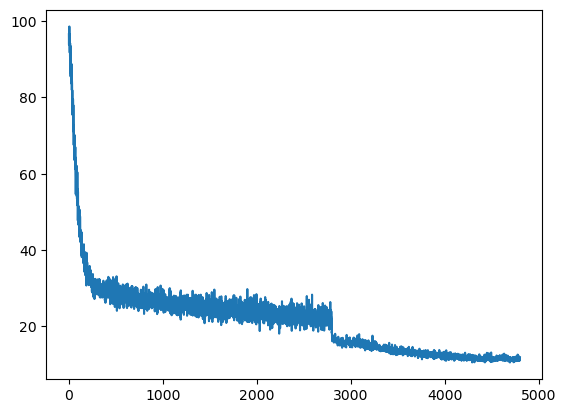

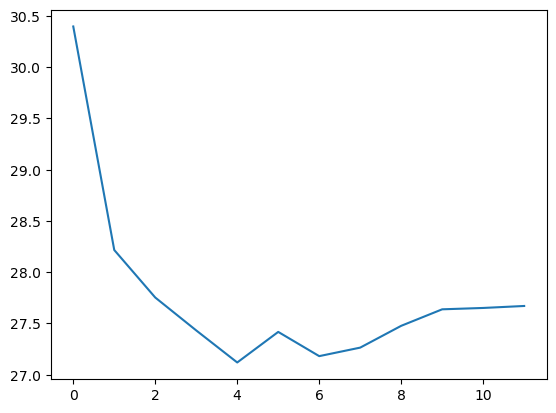

In [27]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()

# Retrieve nearest neighbor in the training set using test set data

In [28]:
## THIS CODE IS COMMENTED OUT BECAUSE IT SHOULD ONLY BE RUN ONCE, AND THEN SUBSEQUENTLY YOU CAN LOAD IN THE SAVED OUTPUTS ##
# import PIL
# def load_and_process_images(directory_path):
#     if not os.path.exists(directory_path): raise Exception(f"The directory does not exist: {directory_path}")

#     # crop along longest dimension first, then do centercrop now that image is square
#     # (this is the same process that the NSD authors said they used)
#     preprocess = transforms.Compose([
#         transforms.Lambda(lambda img: transforms.CenterCrop(max(img.size))(img)),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(), 
#     ])
    
#     all_files = os.listdir(directory_path)
#     jpg_files = [file for file in all_files if file.endswith('.jpg')]
    
#     tensor_list = []
#     image_ids = []  # List to store COCO image_ids (note: these are not the same as NSD 73k ids!)
#     for file in tqdm(jpg_files):
#         with PIL.Image.open(os.path.join(directory_path, file)).convert("RGB") as img:
#             tensor = preprocess(img)
#             tensor_list.append(tensor)
#             image_id = int(file.split(".")[0])
#             image_ids.append(image_id)
    
#     stacked_tensor = torch.stack(tensor_list)
#     print(f"Stacked Tensor Shape: {stacked_tensor.shape}")
#     return stacked_tensor, image_ids

# traincoco_images, traincoco_ids = load_and_process_images('/fsx/proj-fmri/shared/coco/raw_images/train2017/')
# print("traincoco_images", traincoco_images.shape)
# valcoco_images, valcoco_ids = load_and_process_images('/fsx/proj-fmri/shared/coco/raw_images/val2017')
# print("valcoco_images", valcoco_images.shape)

# coco_images = torch.vstack((traincoco_images, valcoco_images))
# coco_ids = np.concatenate((np.array(traincoco_ids), np.array(valcoco_ids)))

# with h5py.File("trainval_coco_images_224_float16.hdf5", 'w') as f:
#     f.create_dataset("images", data=coco_images.half().numpy())
# f.close()
# np.save("trainval_coco_ids.npy", coco_ids)
    
# print("saved coco_images", coco_images.shape)
# print("saved coco_ids", len(coco_ids))

# # annotations ##
# with open("/fsx/proj-fmri/shared/coco_anno/captions_train2017.json", "r") as file:
#     data = json.load(file)
# captions_dict = {}
# for item in data['annotations']:
#     image_id = item['image_id']
#     caption = item['caption']
#     # given multiple possible captions, we take the longest one
#     if image_id not in captions_dict or len(caption) > len(captions_dict[image_id]):
#         captions_dict[image_id] = caption
# with open("/fsx/proj-fmri/shared/coco_anno/captions_val2017.json", "r") as file:
#     data = json.load(file)
# for item in data['annotations']:
#     image_id = item['image_id']
#     caption = item['caption']
#     if image_id not in captions_dict or len(caption) > len(captions_dict[image_id]):
#         captions_dict[image_id] = caption
# np.save("trainval_coco_captions_dict", captions_dict)
# print("saved captions_dict", len(captions_dict))

In [29]:
# prep function to convert from NSD ids to COCO ids
import pandas as pd
stim_df = pd.read_csv('/fsx/proj-fmri/shared/natural-scenes-dataset/nsd_stim_info_merged.csv')
def get_cocoId_from_nsdId(df, nsdId):
    return df.loc[df['nsdId'] == nsdId, 'cocoId'].iloc[0]

# Load images & ids & captions (assuming they were already saved)
f = h5py.File('trainval_coco_images_224_float16.hdf5', 'r')
coco_images = f['images'][:]
coco_images = torch.Tensor(coco_images).to("cpu").to(data_type)
print("coco_images", coco_images.shape)

coco_ids = np.load("trainval_coco_ids.npy")
print("coco_ids", len(coco_ids))
captions_dict = dict(np.load("trainval_coco_captions_dict.npy", allow_pickle=True).item()) # e.g., captions_dict[coco_ids[0]]

coco_images torch.Size([123287, 3, 224, 224])
coco_ids 123287


In [30]:
# # prep large-scale embedding dataset to retrieve from
# minibatch_size=2048
# with torch.no_grad(), torch.cuda.amp.autocast():
#     for batch in tqdm(range(0,len(coco_images),minibatch_size)):
#         if batch==0:
#             clip_target = clip_model.embed_image(coco_images[batch:batch+minibatch_size]).cpu()
#         else:
#             target = clip_model.embed_image(coco_images[batch:batch+minibatch_size]).cpu()
#             clip_target = torch.vstack((clip_target,target))
#     clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

# torch.save(clip_target_norm, "clip_target_norm.pt")
clip_target_norm = torch.load("clip_target_norm.pt")

subject 1
Original Image (test set)


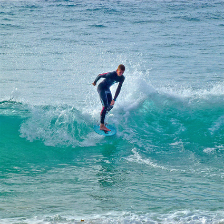

clip_voxels_norm torch.Size([1, 197376])
clip_target_norm torch.Size([123287, 197376])

Nearest neighbors in training set


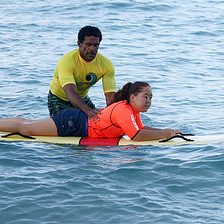

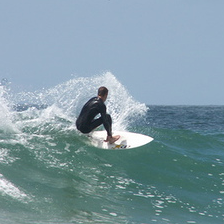

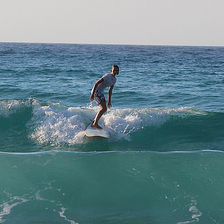

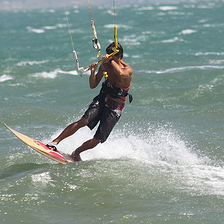

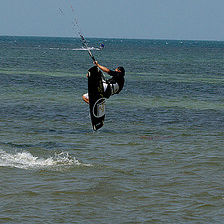


=====
predicted_caption:
 A man riding on top of a surfboard next to a  woman in the ocean.


In [32]:
ii=2
print("subject", subj_list[0])
with torch.no_grad(), torch.cuda.amp.autocast():
    voxel = test_voxel[[ii]].to(device)
    image = test_image[[ii]].to(device)

    print("Original Image (test set)")
    display(utils.torch_to_Image(image))
    
    clip_target = clip_model.embed_image(image).cpu()
    
    voxel_ridge = model.ridge(voxel,0)
    clip_voxels, _, _ = model.backbone(voxel_ridge)    
    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)

    # # replace voxels with ground truth for sanity checking (comment this out!)
    # clip_target = clip_model.embed_image(image).cpu()
    # clip_voxels_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    print("clip_voxels_norm", clip_voxels_norm.shape)
    print("clip_target_norm", clip_target_norm.shape)
    
    picks = torch.argsort(utils.cosine_similarity(clip_voxels_norm.cpu(), 
                                                            clip_target_norm).flatten()).flip(0)[:5]

    print("\nNearest neighbors in training set")
    for ip,p in enumerate(picks):
        display(utils.torch_to_Image(coco_images[[p]]))
        
        if ip==0: 
            predicted_caption = captions_dict[coco_ids[p]]

print("\n=====\npredicted_caption:\n", predicted_caption)

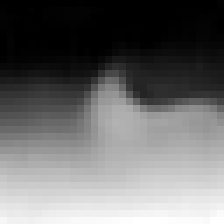

In [33]:
depth_recon=utils.resize(depth_image_[[ii]].view(1,1,32,32).clamp(0,1), 224)
utils.torch_to_Image(depth_recon)

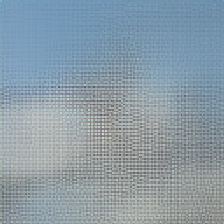

In [34]:
blurry_recon = utils.resize((autoenc.decode(blurry_image_enc_[[ii]]/0.18215).sample / 2 + 0.5).clamp(0,1),224)
utils.torch_to_Image(blurry_recon)

# Feed into Stable Diffusion XL for reconstructions

In [35]:
from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, MultiAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL
from diffusers.utils import load_image, make_image_grid
from controlnet_aux.midas import MidasDetector

# load single adapter
adapter = T2IAdapter.from_pretrained(
  "TencentARC/t2i-adapter-depth-midas-sdxl-1.0", torch_dtype=torch.float16, varient="fp16", cache_dir="/fsx/proj-fmri/shared/cache",
).to("cuda")

# # load multi adapter
# adapter = MultiAdapter(
#     [
#         T2IAdapter.from_pretrained("SargeZT/t2i-adapter-sdxl-multi", torch_dtype=torch.float16, varient="fp16", subfolder="depth", cache_dir="/fsx/proj-fmri/shared/cache"),
#         T2IAdapter.from_pretrained("SargeZT/t2i-adapter-sdxl-multi", torch_dtype=torch.float16, varient="fp16", subfolder="color", cache_dir="/fsx/proj-fmri/shared/cache"),
#     ]
# )
# adapter = adapter.to(torch.float16).to("cuda")

In [36]:
# load euler_a scheduler
model_id = "/fsx/proj-fmri/shared/cache/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/f898a3e026e802f68796b95e9702464bac78d76f"
euler_a = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")

pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16", use_safetensors=True,
).to("cuda")
pipe.enable_xformers_memory_efficient_attention()

# midas_depth = MidasDetector.from_pretrained(
#       "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large", cache_dir="/fsx/proj-fmri/shared/cache").to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

prompt A man riding on top of a surfboard next to a  woman in the ocean.


  0%|          | 0/30 [00:00<?, ?it/s]

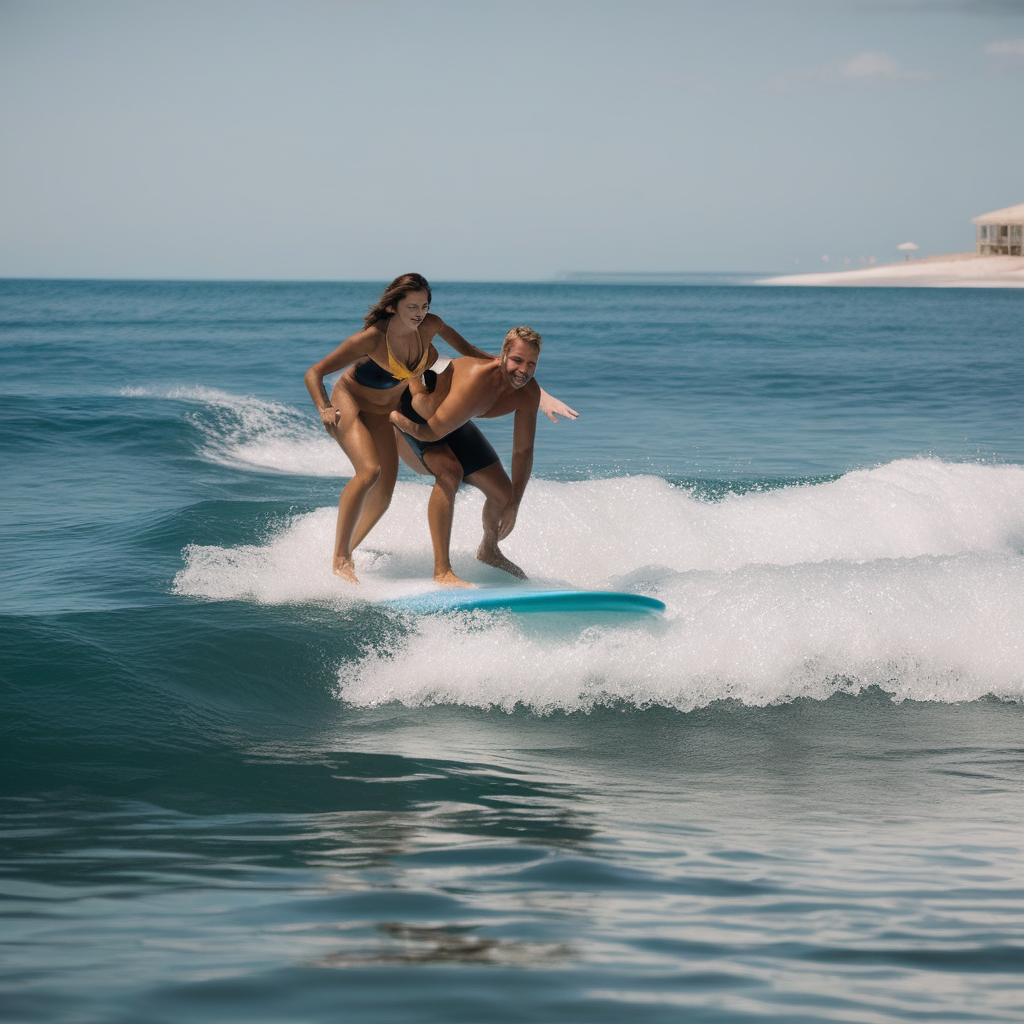

In [41]:
prompt = predicted_caption
print("prompt", prompt)
negative_prompt = "anime, vector, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"

gen_images = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=utils.torch_to_Image(utils.resize(transforms.GaussianBlur(kernel_size=(15,15),sigma=(20,20))(depth_recon[0].repeat(3,1,1)),1024)),
  #image=utils.torch_to_Image(utils.resize(transforms.GaussianBlur(kernel_size=(15,15),sigma=(20,20))(blurry_recon[0]),1024)),
  num_inference_steps=30,
  adapter_conditioning_scale=.5,
  guidance_scale=7.5,  
).images[0]

gen_images

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

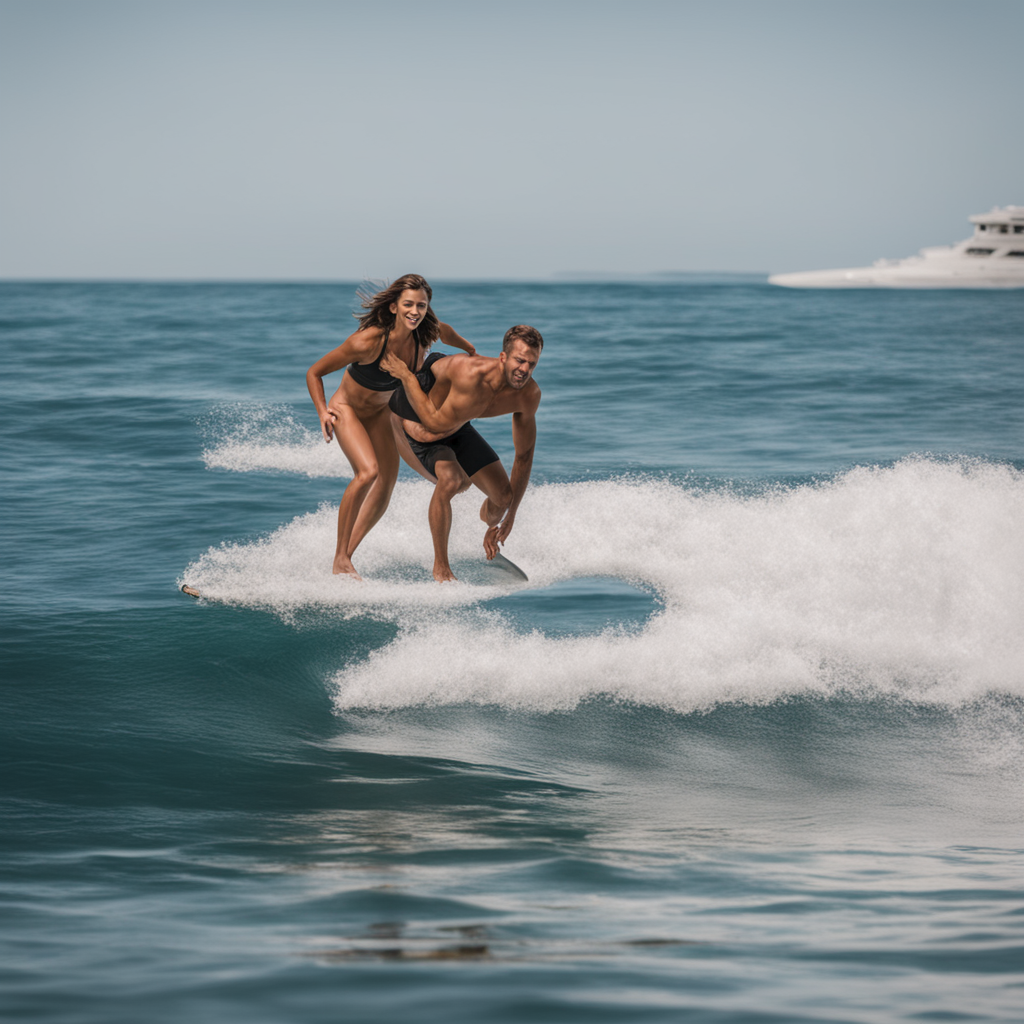

In [45]:
from diffusers import DiffusionPipeline
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=pipe.text_encoder_2,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    cache_dir="/fsx/proj-fmri/shared/cache",
)
refiner.to("cuda")

refined_gen_images = refiner(prompt, image=gen_images).images
refined_gen_images[0]

In [ ]:
# # url = "https://huggingface.co/Adapter/t2iadapter/resolve/main/figs_SDXLV1.0/org_mid.jpg"
# # image = load_image(url)
# image = midas_depth(
#   utils.torch_to_Image(image), detect_resolution=224, image_resolution=1024
# )
# image